In [1]:
import torch as tch
import torch.nn.functional as F
import torch.nn as tchnn
import torch.autograd as tchagd
import torch.optim as tchoptim
from torch.autograd import Variable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
import visdom

In [3]:
#params for the system
e_inp_dim = 28*28
e_out_dim = 100 #z, latent variable
d_inp_dim = 100
d_out_dim = 28*28
n_hidden = 1000
n_iter = 1000
BATCHSZ = 64*4

In [2]:
#visdom client
vis = visdom.Visdom(port=7777)

In [4]:
#encoder network (X -> z)
class Encoder(tchnn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.L1 = tchnn.Linear(e_inp_dim, n_hidden)
        self.L2 = tchnn.Linear(n_hidden, n_hidden)
        self.Ou = tchnn.Linear(n_hidden, e_out_dim*2) #for mu and sigma 
    
    def forward(self, x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = F.relu(self.Ou(x))
        mu = x[:, :e_out_dim]
        sig = x[:, e_out_dim:]
        #need to make sure that sigmas are positive
        #sig = F.softplus(sig)
        return mu, sig
        
    def name(self):
        return 'Encoder'
        

In [5]:
class Decoder(tchnn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.L1 = tchnn.Linear(d_inp_dim, n_hidden)
        self.L2 = tchnn.Linear(n_hidden, n_hidden)
        self.Ou = tchnn.Linear(n_hidden, d_out_dim)
    
    def forward(self, x):
        #print('yay')
        #print('dbg: {}'.format(x.size()))
        x = F.relu(self.L1(x))
        #print('dbg: {}'.format(x.size()))
        x = F.relu(self.L2(x))
        x = F.sigmoid(self.Ou(x))
        return x
    
    def name(self):
        return 'Decoder'

In [6]:
#xavier weight initialisation, suggested to be good
def wt_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        my_xavier(m.weight.data.cpu())
        my_xavier(m.bias.data.cpu())

In [7]:
def my_xavier(W):
    size = W.size()
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(tch.randn(*size) * xavier_stddev, requires_grad=True).cuda()

In [8]:
#data loading and related stuff
MNISTX_train = np.load('../gmmGAN/MNISTX_train.npy')
def MNIST_gen(X, BATCHSZ):
    X = X.reshape(-1,784) #serialize images
    while(True):
        databatch = random.sample(list(X), BATCHSZ)
        databatch = np.array(databatch)
        yield databatch

MNISTd = MNIST_gen(MNISTX_train, BATCHSZ)

In [66]:
print(next(MNISTd)[0,:])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

In [18]:
a = Variable(tch.randn(3,4))
b = Variable(tch.randn(4,5))
print(a,b)
a@b

Variable containing:
 0.5330  0.3786  0.2018  0.4780
-0.9743  0.3398  0.0127  1.0500
 1.2010 -0.1877 -1.1156 -1.8100
[torch.FloatTensor of size 3x4]
 Variable containing:
-2.0501  0.3971  1.2938 -0.7058  1.0019
 0.3344  1.2420  1.3532  1.2340  1.4716
 1.1825  0.0302  0.0131  1.6813  0.1892
 0.5447 -2.5606  0.7415  1.1534 -1.4724
[torch.FloatTensor of size 4x5]



Variable containing:
-0.4671 -0.5359  1.5589  0.9816  0.4256
 2.6981 -2.6533 -0.0220  2.3395 -2.0199
-4.8300  4.8448 -0.0566 -5.0425  3.3812
[torch.FloatTensor of size 3x5]

In [9]:
#mnist batch plotter
def plotter(batch_data):
    #batch_data = batch_data.numpy()
    n = batch_data.shape[0]
    for i in range(n):
        plt.subplot(8,8,i+1)
        plt.imshow(batch_data[i].reshape(-1,28), cmap='gray', interpolation='none')
        plt.axis('off')
    plt.show()

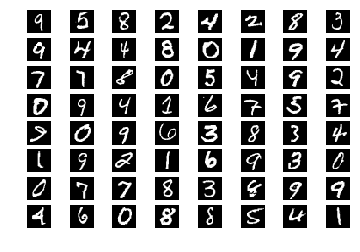

In [10]:
plotter(next(MNISTd)[0:64])

In [23]:
d = next(MNISTd)
d = d.reshape(-1,1,28,28)
# print(d.shape)
vis.images(d[0:45,:,:,:],
          opts=dict(title='Random!', caption='How random.'),)

'window_35ca4b20712fdc'

In [61]:
#pretraining
E = Encoder().cuda()
D = Decoder().cuda()
E = E.double()
D = D.double()
E.apply(wt_init)
D.apply(wt_init)
print(E)
print(D)

Encoder (
  (L1): Linear (784 -> 1000)
  (L2): Linear (1000 -> 1000)
  (Ou): Linear (1000 -> 200)
)
Decoder (
  (L1): Linear (100 -> 1000)
  (L2): Linear (1000 -> 1000)
  (Ou): Linear (1000 -> 784)
)


In [42]:
list(E.parameters())+ list(D.parameters())

[Parameter containing:
 -1.7827e-02 -1.7806e-02 -5.9077e-03  ...  -2.1912e-02 -5.8538e-03 -1.0049e-02
 -2.1709e-02  4.7425e-02 -9.5942e-04  ...   9.5575e-03  1.2265e-02 -1.1661e-02
 -1.8080e-02  3.8126e-03 -1.7482e-03  ...  -2.3244e-03  1.3635e-02  6.2563e-02
                 ...                   ⋱                   ...                
 -3.3585e-03  1.3208e-02  1.7590e-02  ...  -1.6484e-03  1.8603e-02  7.8758e-03
  3.8834e-02 -5.0585e-02  8.1510e-03  ...   1.9907e-02  1.9622e-02 -1.3050e-02
  1.4259e-02 -4.8798e-03  1.1959e-02  ...  -1.4296e-02 -1.0562e-02  1.6351e-03
 [torch.cuda.DoubleTensor of size 1000x784 (GPU 0)], Parameter containing:
  0
  0
  0
 ⋮ 
  0
  0
  0
 [torch.cuda.DoubleTensor of size 1000 (GPU 0)], Parameter containing:
  1.0972e-02  2.2923e-02 -1.1466e-02  ...  -1.0621e-02  2.3385e-02 -3.1726e-02
 -4.1588e-02 -9.0409e-03  8.5964e-03  ...  -1.8006e-02 -1.6048e-02  2.9407e-02
  1.6162e-02  1.8110e-02  1.6426e-03  ...   2.0850e-02  1.3581e-02  1.2376e-02
             

In [62]:
optim = tchoptim.Adam(list(E.parameters())+ list(D.parameters()), lr=1e-3)

In [63]:
def sample_z(mu, sig):
    e = Variable(tch.randn(BATCHSZ, e_out_dim).cuda().double())
    r = mu + (e*tch.exp(sig/2))
    return r
    

64 generated samples after itr: 0


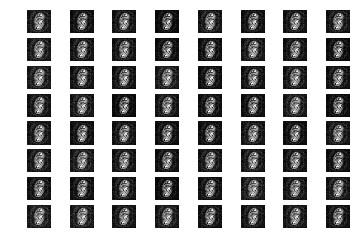

64 generated samples after itr: 100


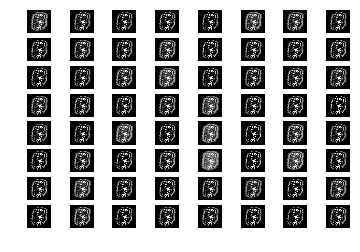

64 generated samples after itr: 200


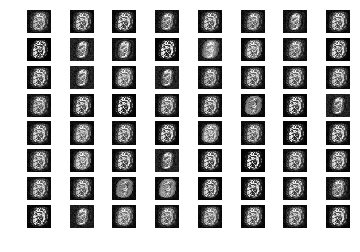

64 generated samples after itr: 300


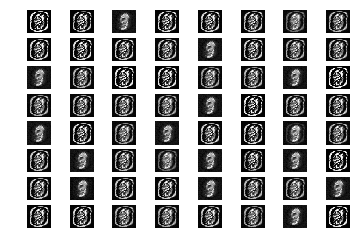

64 generated samples after itr: 400


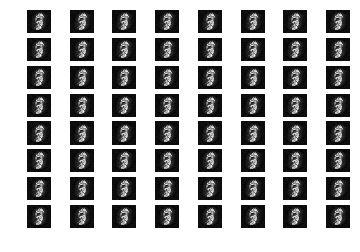

64 generated samples after itr: 500


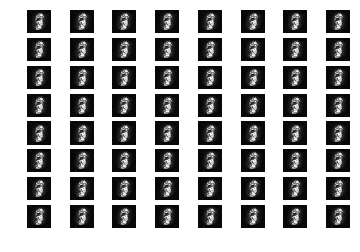

64 generated samples after itr: 600


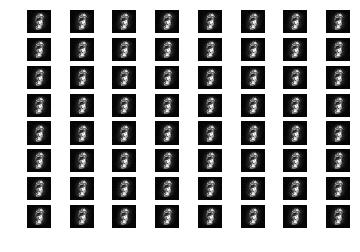

64 generated samples after itr: 700


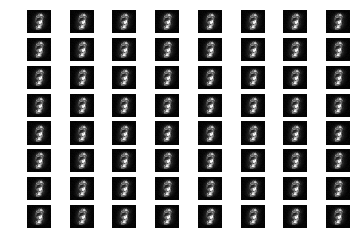

64 generated samples after itr: 800


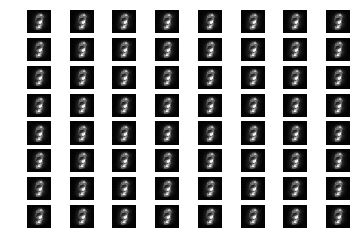

64 generated samples after itr: 900


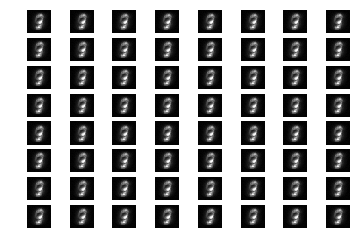

In [67]:
#training
for itr in range(n_iter):
    X = next(MNISTd)
    X = Variable(tch.from_numpy(X).cuda())
    #print(X.size())
    #through the encoder
    z_mu, z_log_sig = E(X)
    z = sample_z(z_mu, z_log_sig)
    #through the decoder
    z = z.cuda()
    
    d_out = D(z)
    #loss
    recon_loss = F.binary_cross_entropy(d_out, X)
    KL_div = tch.mean(0.5 * tch.sum(tch.exp(z_log_sig) + z_mu**2 - 1. - z_log_sig, 1))
    loss = recon_loss + KL_div
    
    loss.backward()
    optim.step()
    
    #print results sometimes
    if itr%100 == 0:
        print('64 generated samples after itr: {}'.format(itr))
        plotter(d_out.data.cpu().numpy()[0:64,:]) 